In [1]:
import torch
import torch.nn as nn

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
import gc
import torch
torch.cuda.empty_cache()
# del variable #delete unnecessary variables 
gc.collect()

40

In [4]:
# loading the dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [5]:
# dir_original = "D:/MTP/U_net/IMg/"
dir_val =r"ValidationImages"
import os
validation_images=[] 
val_names = []
for img_name in os.listdir(dir_val):
#     print(img_name)
    val_names.append(img_name)
    imgp = os.path.join(dir_val,img_name)
    img = cv2.imread(imgp,cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    validation_images.append(img)

print("validation_images: ",len(validation_images))
    
    
val_mask = r"ValidationMasks"
vmask_img=[] 
vmask_names = []
for mask_name in os.listdir(val_mask):
#     print(mask_name)
    vmask_names.append(vmask_names)
    maskp = os.path.join(val_mask,mask_name)
    mask = cv2.imread(maskp,0)
    mask = cv2.resize(mask, (256,256))
#     print(mask.shape)
    vmask_img.append(mask)
    
print("validation_Masks: ",len(vmask_img)) 
    
img_H=256
img_W=256
validation_images = np.array(validation_images)
print(validation_images.shape)
validation_images_reshp = np.reshape(validation_images,(-1,1,img_H,img_W))
print(validation_images_reshp.shape)

vmask_img = np.array(vmask_img)
print(vmask_img.shape)
vmask_img_reshp = np.reshape(vmask_img,(-1,1,img_H,img_W))
print(vmask_img_reshp.shape)

validation_images_reshp=torch.from_numpy(validation_images_reshp)
print(validation_images_reshp.size())
vmask_img_reshp=torch.from_numpy(vmask_img_reshp)
print(vmask_img_reshp.size()) 

# validation_images_reshp  vmask_img_reshp

validation_images:  15
validation_Masks:  15
(15, 256, 256)
(15, 1, 256, 256)
(15, 256, 256)
(15, 1, 256, 256)
torch.Size([15, 1, 256, 256])
torch.Size([15, 1, 256, 256])


In [6]:
batch_size =5
  
valImg_loader = torch.utils.data.DataLoader(validation_images_reshp, batch_size=batch_size
                                          )

ValMask_loader = torch.utils.data.DataLoader(vmask_img_reshp, batch_size=batch_size
                                         )

# valImg_loader ValMask_loader

In [7]:
# l=len(next(iter(train_loader)))
# print(len(train_loader)*l)
# print(len(test_loader)*l)

In [8]:
# len(next(iter(train_loader)))

In [9]:
# %matplotlib inline
# from IPython.display import Image
# Image('unet.jpg')

In [10]:
# Device configuration
device = torch.device('cuda')

In [11]:
""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
# in_c = no of input channels out_c= no of output channels  padding=1 means "same"
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        # print("conv_block1: ", x.shape)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        # print("conv_block2: ", x.shape)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        # print("decoder x1.shape: ",x.shape)
        x = torch.cat([x, skip], axis=1)
        # print("decoder x2.shape: ",x.shape)
        x = self.conv(x)
        # print("decoder x2.shape: ",x.shape)

        return x
    
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        # print("inputs.shape: ",inputs.shape)
        s1, p1 = self.e1(inputs)
        # print("s1.shape: ",s1.shape, "p1.shape: ",p1.shape)
        s2, p2 = self.e2(p1)
        # print("s2.shape: ",s2.shape, "p2.shape: ",p2.shape)
        s3, p3 = self.e3(p2)
        # print("s3.shape: ",s3.shape, "p3.shape: ",p3.shape)
        s4, p4 = self.e4(p3)
        # print("s4.shape: ",s4.shape, "p4.shape: ",p4.shape)

        """ Bottleneck """
        b = self.b(p4)
        # print("botlleneck shape :",b.shape)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        # print(d4.shape)
        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

In [12]:
size = (256, 256)
num_epochs =120
lr = 0.0001
model = build_unet().to(device)
# criterion = nn.BCEWithLogitsLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

criterion = nn.MSELoss()
# loss = torch.sqrt(criterion(x, y))

In [13]:
from torch.utils.data import Dataset

import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2

class DatasetUnet(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, img_path, mask_path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_Img = img_path
        self.root_Mask = mask_path
        
        self.img_dir = os.listdir(img_path)
        self.transform = transform

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
    
        img_name = self.img_dir[idx]
#         print(img_name)
        img = cv2.imread(os.path.join(self.root_Img, img_name),0)
        img = cv2.resize(img, (256,256))
        img =np.reshape(img,(1,256,256))
        img=torch.from_numpy(img)
#         img = torch.einsum("npq->qnp",img)
        
        mask= cv2.imread(os.path.join(self.root_Mask, img_name),0) # here image_name and mask name are same 
        mask = cv2.resize(mask, (256,256))
        mask = np.reshape(mask,(1,256,256))
        mask=torch.from_numpy(mask)
#         mask = torch.einsum("npq->qnp",mask)
        return img, mask

In [14]:
img_path = r"Train_Images"
mask_path = r"Train_Masks"
batch_size = 16
obj = DatasetUnet(img_path, mask_path)
dataloader = DataLoader(obj,batch_size=batch_size,
                        shuffle=True, num_workers=0)
print(obj.__len__())
# hyperparameters



245


In [15]:
train_losses = []
validation_losses=[]
vl =10
for epoch in range(num_epochs):
    epoch_loss = []
    for i, (images, labels) in enumerate(dataloader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = (images.float()/255.0).to(device)
#         print(images.shape)
        labels = (labels.float()/255.0).to(device)
        # images = images.float()/255.0
        # labels = labels.float()/255.0
        # print(images)
        # Forward pass
        outputs = model(images)
        # print(outputs.shape)
#         loss = criterion(outputs, labels)
        loss = torch.sqrt(criterion(outputs, labels))
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.cpu().data.numpy())
#         valImg_loader ValMask_loader
        # validation data
    val_losses = []
    for j, (val_images, val_labels) in enumerate(zip(valImg_loader,ValMask_loader)):
        pred_val = model((val_images.float()/255.0).to(device))
        pred_masks = (val_labels.float()/255.0).to(device)
#         val_loss = criterion(pred_val, pred_masks)
        val_loss = torch.sqrt(criterion(pred_val, pred_masks))
        val_losses.append(val_loss.cpu().data.numpy())
        

    mean_val_loss = np.array(val_losses).mean()
        
    train_losses.append(loss)
    mean_train_loss = np.array(epoch_loss).mean()
    validation_losses.append(mean_val_loss)
    
#     code to save the best model
    if mean_val_loss< vl:
        print(f"Best Model Saved at validation loss :{mean_val_loss:.4f}")
        PATH = './BestModel.pth'
        torch.save(model.state_dict(), PATH)
        vl = mean_val_loss
#     if (i+1) % 2 == 0:
#         #print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{batch_size}], Loss: {loss.item():.4f}, Val_loss:{mean_val_loss:.4f} ')
#         pass
    print (f'Epoch [{epoch+1}/{num_epochs}], Epoch Loss: {mean_train_loss.item():.4f}, Val_loss:{mean_val_loss:.4f} ')
        
print('Finished Training')
PATH = './CrackSegment.pth'
torch.save(model.state_dict(), PATH)

Best Model Saved at validation loss :0.1621
Epoch [1/120], Epoch Loss: 0.2340, Val_loss:0.1621 
Best Model Saved at validation loss :0.1620
Epoch [2/120], Epoch Loss: 0.1704, Val_loss:0.1620 
Best Model Saved at validation loss :0.1503
Epoch [3/120], Epoch Loss: 0.1633, Val_loss:0.1503 
Best Model Saved at validation loss :0.1489
Epoch [4/120], Epoch Loss: 0.1526, Val_loss:0.1489 
Best Model Saved at validation loss :0.1364
Epoch [5/120], Epoch Loss: 0.1469, Val_loss:0.1364 
Best Model Saved at validation loss :0.1272
Epoch [6/120], Epoch Loss: 0.1481, Val_loss:0.1272 
Epoch [7/120], Epoch Loss: 0.1485, Val_loss:0.1427 
Best Model Saved at validation loss :0.1251
Epoch [8/120], Epoch Loss: 0.1432, Val_loss:0.1251 
Epoch [9/120], Epoch Loss: 0.1442, Val_loss:0.1313 
Epoch [10/120], Epoch Loss: 0.1451, Val_loss:0.1448 
Epoch [11/120], Epoch Loss: 0.1399, Val_loss:0.1267 
Epoch [12/120], Epoch Loss: 0.1328, Val_loss:0.1296 
Epoch [13/120], Epoch Loss: 0.1371, Val_loss:0.1306 
Epoch [14/12

In [16]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [17]:
# Dice similarity function
def dice(pred, true, k = True):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

# dice_score = dice(y_p, y_t, k = True) #255 in my case, can be 1 
# print ("Dice Similarity: {}".format(dice_score))

In [18]:
def Y_Pred(input_img_path):
    test_img=[]
    print(os.listdir(input_img_path))
    for img_name in os.listdir(input_img_path):
        imgp = os.path.join(input_img_path,img_name)
        img = cv2.imread(imgp,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256,256))
        test_img.append(img)

    test_img = np.array(test_img)
    # print(test_img.shape)
    test_imgR = np.reshape(test_img,(-1,1,img_H,img_W))
    # print(test_imgR.shape)
    test_imgR=torch.from_numpy(test_imgR)/255.0
    test_imgR=test_imgR.float()

    # giving test image input to the model
    predicted = model(test_imgR) 
    predicted =np.where(predicted > 0.5, 1, 0)   
    return np.array(predicted)

In [19]:
test_Maskdirectory =r"Test_Masks"
def Y_true(mask_path):
    # print("Y_True function: ")
    mask_img = []
    print(os.listdir(mask_path))
    for img_name in os.listdir(mask_path):
        imgp = os.path.join(mask_path,img_name)
        img = cv2.imread(imgp,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256,256))
        mask_img.append(img)

    mask_img = np.array(mask_img)
    # print(mask_img.shape)
    mask_img = np.reshape(mask_img,(-1,1,img_H,img_W))
    # print(mask_img.shape)
    mask_img=torch.from_numpy(mask_img)/255.0
    mask_img=mask_img.float()
    mask_img=np.array(mask_img)
    mask_img =np.where(mask_img > 0.5, 1, 0)
    return mask_img

y_t = Y_true(test_Maskdirectory)
y_t.shape

['119.jpg', '79.jpg', '106.jpg', '12.jpg', '54.jpg', '134.jpg', '124.jpg', '41.jpg', '75.jpg', '1.jpg']


(10, 1, 256, 256)

In [20]:
from sklearn.metrics import confusion_matrix,accuracy_score,jaccard_score
def EvaluationOfSegmentation(test_img_path, test_mask_path):
    y_p = Y_Pred(test_img_path).flatten()
    y_t = Y_true(test_mask_path).flatten()
    print()
    print(" Various Evaluations for the U-Net segmentations are as follows :")
    print()
    acc_value = accuracy_score(y_t,y_p)
    print(f"Accuracy score is: {acc_value}")

    jaccard=jaccard_score(y_t, y_p, average='macro')
    print(f"Jaccard score is: {jaccard}")

    dice_score = dice(y_p, y_t, k = True) 
    print ("Dice Similarity: {}".format(dice_score))

    

    tn, fp, fn, tp = confusion_matrix(y_t, y_p).ravel()
    print(tn, fp, fn, tp)

    dice_coff = 2*tp/(2*tp + fp + fn)
    jaccard_index = tp/(tp + fp + fn)
    print("Dice Cofficient : ", dice_coff)
    print("Jaccard Index : ", jaccard_index)

    print()
    print("Confusion Matrix:")
    print(confusion_matrix(y_t, y_p))
    print()
    precision = precision_score(y_t, y_p)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_t, y_p)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_t, y_p)
    print('F1 score: %f' % f1)

In [21]:
# loading the model 
model = build_unet()
model.load_state_dict(torch.load('CrackSegment.pth'))
EvaluationOfSegmentation(r"Test_Images", r"Test_Masks")

['119.jpg', '79.jpg', '106.jpg', '12.jpg', '54.jpg', '134.jpg', '124.jpg', '41.jpg', '75.jpg', '1.jpg']
['119.jpg', '79.jpg', '106.jpg', '12.jpg', '54.jpg', '134.jpg', '124.jpg', '41.jpg', '75.jpg', '1.jpg']

 Various Evaluations for the U-Net segmentations are as follows :

Accuracy score is: 0.9781982421875
Jaccard score is: 0.8910685004937403
Dice Similarity: 0.8926489150688225
581668 5110 9178 59404
Dice Cofficient :  0.8926489150688225
Jaccard Index :  0.8061119253107528

Confusion Matrix:
[[581668   5110]
 [  9178  59404]]

Precision: 0.920792
Recall: 0.866175
F1 score: 0.892649


In [22]:
images_names = os.listdir(r"Test_Images")
Img_Testpath = r"Test_Images"
Mask_Testpath = r"Test_Masks"

['119.jpg', '79.jpg', '106.jpg', '12.jpg', '54.jpg', '134.jpg', '124.jpg', '41.jpg', '75.jpg', '1.jpg']


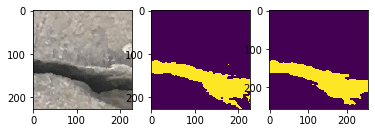

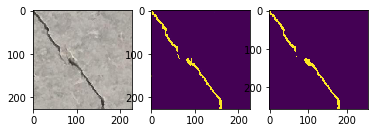

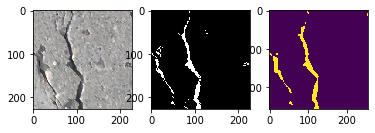

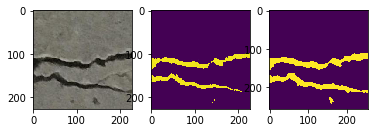

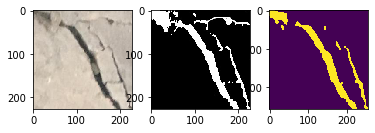

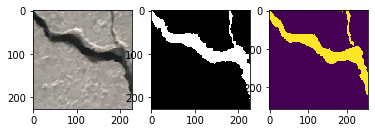

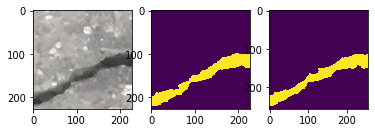

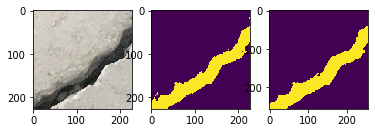

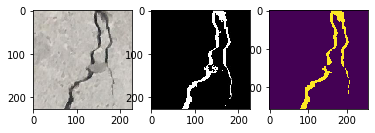

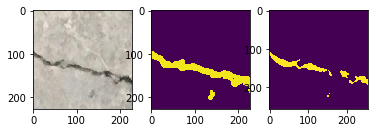

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

test_results = Y_Pred(r"Test_Images")
for x in range(len(os.listdir(r"Test_Images"))):
#     print(x)
    Orgimg = plt.imread(os.path.join(Img_Testpath, images_names[x]))
    mask = plt.imread(os.path.join(Mask_Testpath, images_names[x]))
    
    p =test_results[x]
    pred=np.reshape(p, (256,256))
    plt.imsave(os.path.join(r"Results","res"+images_names[x]), pred, cmap=cm.gray)
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(Orgimg)
    axarr[1].imshow(mask)
    axarr[2].imshow(pred)
    

In [24]:
t_loss = []
v_loss = []
for i in range(len(train_losses)):
    t_loss.append(train_losses[i].cpu().detach().numpy())
    v_loss.append(validation_losses[i])    

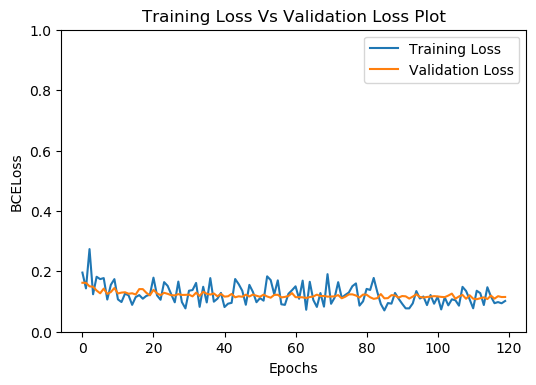

In [25]:
epoch = [i for i in range(num_epochs)]

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
# plot the data 
plt.title('Training Loss Vs Validation Loss Plot') 
plt.ylim(0, 1)
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.plot(epoch, t_loss, color ='tab:blue') 
plt.plot(epoch, v_loss, color ='tab:orange') 
plt.legend(['Training Loss', 'Validation Loss'])
plt.savefig('VsLosses.png')
plt.savefig('VsLosses.pdf')
plt.show()

In [26]:
print(len(train_losses) ,len(validation_losses))

120 120


In [27]:
plt.savefig('VsLosses.png')
plt.savefig('VsLosses.pdf')

<Figure size 600x400 with 0 Axes>

In [ ]:
(%)